# To study BNS lensing rate at O3 sensitivity 

In [1]:
import numpy as np
import bilby
import pylab as plt
from matplotlib import pyplot
import pycbc
from pycbc.detector import Detector
from datetime import datetime
from scipy.integrate import quad 

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

In [2]:
# for redshift to luminosity distance conversion
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
import astropy.units as u

* for calculation of $D_{hor}^{avg}$, refer to BNS_Range.ipynb 

# boolean function for detectable BNS
* $$Bool\text{_}D_{hor} = \left\{\int_{2}^{\infty}\Theta[D_l(z)<D_{hor}(\mu,z)] P(\mu) d\mu \right\}$$
* Probability desity function of lens amplification: $P(\mu)=(1/8)\mu^{-3}$

# affect of lenisng magnification and red-shift
* considering optimal orientation and source location,
* both $D_l$ and $D_{hor}$ will affect the same by $\mu$.
* from BNS_Range.ipynb, 
$$ D_{hor}^{lensed} = \left( \frac{1 Mpc}{\rho_{th}^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z_{hor})\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu} $$
* if a particular event has SNR$=\rho$ with luminosity distance ($D_l$)
$$ D_l^{lensed} = \left( \frac{1 Mpc}{\rho^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z)\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu} $$

* for the event to be detectable, we need the condition $\rho^{lensed}\geq \rho_{th}^{lensed}$
$$ \left( \frac{1 Mpc}{D_l^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z)\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu} \geq \left( \frac{1 Mpc}{D_{hor}^{lensed}} \right) \Big(\mathcal{M_{source}}(1+z_{hor})\Big)^{5/6} \times \frac{\rho_{1/2}}{\mu}$$
* with simplification,
$$ D_{hor}^{lensed}\left( \frac{1+z}{1+z_{hor}} \right)^{5/6} \geq D_l^{lensed} $$
$$ D_{hor}\left( \frac{1+z}{1+z_{hor}} \right)^{5/6} \geq D_l $$
* as $D_{hor}^{lensed}$ and $D_l^{lensed}$ affect the same way by lensing.

In [3]:
# considering only L1 
#for calculation of Dhor average, refer to BNS_Range.ipynb 
dhor_original = 189.28491385817784 #Mpc
def Bool_lensed(z, dhor_ori):
    
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value #Mpc
    # find BNS horizon
    # considering only L1
    # scaling due to red-shifted chirp mass
    z_ori = z_at_value(Planck18.luminosity_distance, dhor_ori*u.Mpc).value
    dhor = dhor_ori * (1+z)**(5/6) / (1+z_ori)**(5/6)

    if(Dl/dhor<np.sqrt(2)):
        bool_lens = 1.
    else:
        bool_lens = 4.*(dhor/Dl)**4
    
    return(bool_lens)

In [4]:
# test
Bool_lensed(1, 1000)

0.010384477333575688

# BBH/BNS merger rate

* merger rate as given in https://arxiv.org/abs/2204.12977: $ R(z,m) = R_0 g(z) f(m) \rho^{-1}$
* since we are considering only distance, mass pdf will integarte out to 1.
* therefore, $ R(z) = R_0 g(z) \rho^{-1}$
* z: redshift
* $\rho$: model dependent parameter
* $R_0$: local mereger rate of BNS, $13<R_0<1900$ $Gpc^{-3} yr^{-1}$
* $$ g(z)=C(1+z)^{\alpha}\left[ 1+\left( \frac{1+z}{1+z_p} \right)^{\alpha+\beta} \right]$$
* $\rho=1,\alpha=2.7,\beta=2.9,z_p=1.9,\gamma=0,m_{min}=1,m_{max}=2.5$ for baseline model of BNS.

In [41]:
def g_(z,a,b,zp):
    C = 1+(1+zp)**(-a-b) # ensures that g(z=0) = 1
    
    return( C*(1+z)**a * ( 1 + ((1+z)/(1+zp))**(a+b) )**(-1) )

# the value of local merger density rate R0 doesnt matter in the end as we are intersted only in rate ratio
def merger_rate_desity(z, R0=100, rho=1., a=2.7,b=2.9,zp=1.9,gamma=0,m_min=1,m_max=2.5):
    
    g = g_(z,a,b,zp)
    rate = R0*g*(rho**-1)
    return(rate)

* To plot the merger rate variation with red shift

In [42]:
rate_ = []
z_ = np.linspace(0,15,1000)
for zz in z_:
    rate_.append(merger_rate_desity(zz))
rate_ = np.array(rate_)

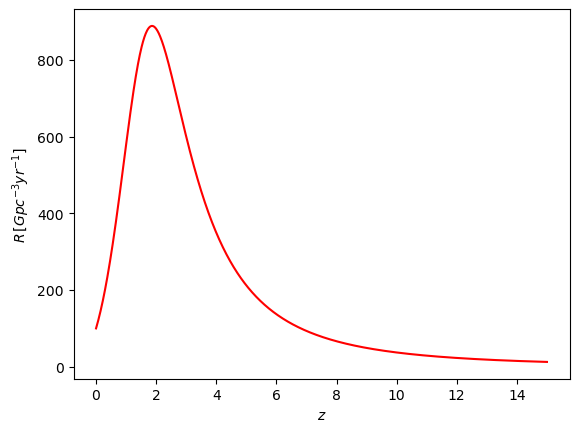

In [43]:
plt.plot(z_, rate_, color='red' )
plt.xlabel(r"$z$")
plt.ylabel(r"$R\,[Gpc^{-3} yr^{-1}]$")
plt.show()

# optical depth
* $\mathcal{D}_c$ : co-moving distance of the source
* as given in equation 18, https://arxiv.org/abs/2204.12977:
$$ \tau(z) = \left(\frac{\mathcal{D}_c(z)}{62.2Gpc}\right)^3 $$

In [44]:
def optical_depth(z):
    # z to luminosity_distance (Dl) conversion
    Dc = Planck18.comoving_distance(z).value*1e-3  # in Gpc
    return( (Dc/62.2)**3 )

In [45]:
opticaldepth = []
z_ = np.linspace(0,5,1000)
for zz in z_:
    opticaldepth.append(optical_depth(zz))
opticaldepth = np.array(opticaldepth)

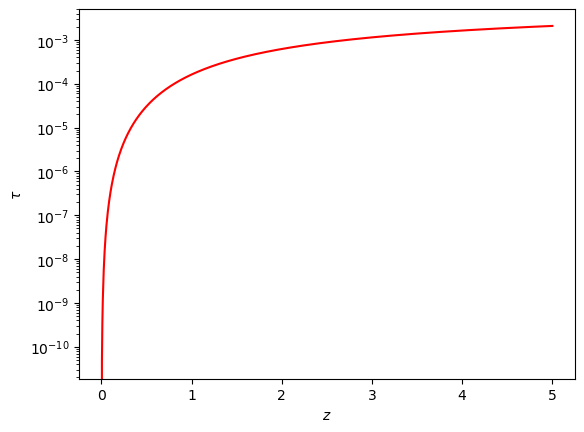

In [46]:
pyplot.plot(z_, opticaldepth, color='red' )
pyplot.yscale('log')
pyplot.xlabel(r"$z$")
pyplot.ylabel(r"$\tau$")
pyplot.show()

# Differential comoving volume element 
* $ \frac{dV_c}{dz} $

In [87]:
def dVc_dz(z):
    return(4*np.pi*Planck18.differential_comoving_volume(z).value)*1e-9

In [88]:
# test
dVc_dz(1)

360.09325155588954

# Rate of lensing

$$ R_L = \int_{0}^{\infty}dz \frac{R(z)}{1+z}\tau(z)\frac{dV_c}{dz}\left\{\int_{2}^{\infty}\Theta[D_l(z)<D_{hor}(\mu)] P(\mu) d\mu \right\} $$

In [89]:
def integrand(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*optical_depth(z)*dVc_dz(z)*Bool_lensed(z, dhor_) )

In [90]:
# integration over source redshift
R_sl = quad(integrand, 0, np.inf, args=(dhor_original))[0]

# Unlensed events' rate

$$ R_U = \int_{0}^{\infty}dz \frac{R(z)}{1+z}\frac{dV_c}{dz} \Theta[D_l(z)<D_{hor}^{original}] $$

In [91]:
def Bool_unlensed(z, dhor_ori):
    
    # z to luminosity_distance (Dl) conversion
    Dl = Planck18.luminosity_distance(z).value

    return(int(Dl<dhor_ori))

In [92]:
# redshift correponding to Dhor_original (at L1 sensitivity of O3)
print('Dhor={}, z={}'.format(dhor_original, z_at_value(Planck18.luminosity_distance, dhor_original*u.Mpc).value ))

Dhor=189.28491385817784, z=0.041423998503087325


In [93]:
BNSdetection = []
z_ = np.linspace(0,0.2,1000)
for zz in z_:
    BNSdetection.append(Bool_unlensed(zz, dhor_original))
BNSdetection = np.array(BNSdetection)

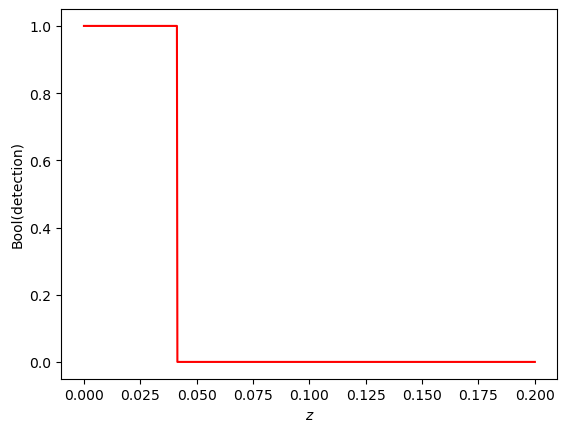

In [94]:
plt.plot(z_, BNSdetection, color='red' )
plt.xlabel(r"$z$")
plt.ylabel(r"Bool(detection)")
plt.show()

In [95]:
def integrand2(z, dhor_):
    return( merger_rate_desity(z)/(1+z)*dVc_dz(z)*Bool_unlensed(z, dhor_) )

In [96]:
# integration over redshift
R_u = quad(integrand2, 0, np.inf, args=(dhor_original))[0]

In [97]:
R_u

2.647916364187082

In [98]:
R_sl

0.0007970322864003592

# relative difference between rate of lensed and unlensed events 

In [99]:
R_u/R_sl

3322.2197009683005

* 1 in 3322 BNS detection are lensed event (O3 run) 

In [100]:
quad(integrand2, 0, np.inf, args=(74))[0]/quad(integrand, 0, np.inf, args=(74))[0]

8169.65025190644